# Load covidtracking data and make some plots

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytoolsMH as ptMH
import pandas as pd
import seaborn as sns
import os,sys
import scipy.io
import scipy.stats as ss
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import json
import datetime, dateutil.parser

sns.set_style('whitegrid')
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

mpl.rc('pdf', fonttype=42) # embed fonts on pdf output 

r_ = np.r_

## covidtracking.com data

In [2]:
r = requests.get('https://covidtracking.com/api/states/daily')
data = r.json()
ctDf = pd.DataFrame(data)

# save current data
datestr = datetime.datetime.now().strftime('%y%m%d')
ctDf.to_hdf('./ct-data/covidtracking-data-%s.h5'%datestr, key='ct', complevel=9, complib='zlib')

In [3]:
params = pd.DataFrame(index={'DC','MD','VA','NY'}, columns=['fullname'])
params.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
params.loc[:,'labYOff'] = pd.Series({ 'DC': -15, 'MD': +10, 'VA': -10, 'NY':-15})
params.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': +5, 'NY': 0})
params.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NY': 0.8})

display(params)


,fullname,labYOff,labXOff,lw
VA,Virginia,-10,5,2.0
MD,Maryland,10,0,2.0
DC,District of Columbia,-15,0,2.0
NY,NaN,-15,0,0.8


KeyError: 0

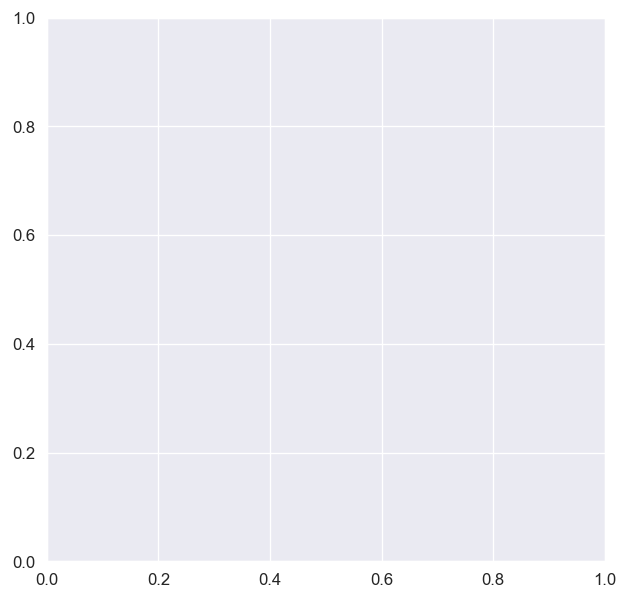

In [7]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)


def plot_state(state='DC', ax=ax):
    desIx = ctDf.state == state
    ys = ctDf.loc[desIx,'positive']
    dtV = pd.to_datetime(ctDf.loc[desIx,'date'], format='%Y%m%d')
    xs = (dtV - dtV.iloc[-1])
    ctDf.loc[desIx,'day0'] = xs
    xs = [x.days for x in xs]


    ph, = ax.plot(xs, ys, marker='.', label=state, lw=2, markersize=9)
    if state in params.index:
        ah = ax.annotate(state, xy=(xs[1],ys.iloc[1]), xycoords='data', 
                    xytext=(params.loc[state,'labXOff'], params.loc[state,'labYOff']),
                    textcoords='offset points',
                    color=ph.get_color(),
                    fontweight='bold', 
                    fontsize=12)
        lw = params.loc[state,'lw']
        ph.set_linewidth(lw)
        if lw < 1:
            ph.set_markersize(3)
            ph.set_color('0.4')
            ah.set_color('0.4')


plot_state('DC')
plot_state('MD')
plot_state('VA')
plot_state('NY')

lp = r_[1,2,5]
yt = np.hstack((lp*10,lp*10**2,lp*10**3,lp*10**4,10**5))
plt.yticks(yt,yt)

ax.set_yscale('log')
ax.set_ylabel('Cases', fontsize=13)
ax.set_xlabel('Days', fontsize=13)
plt.setp(ax.get_xticklabels(), fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: '{:,.0f}'.format(x)))
ax.get_xlim()

#ax.set_yticklabels(['%d'%x for x in yt])
ax.set_xlim([0,30])
ax.set_ylim([10, ax.get_ylim()[1]])

# inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width=1.5, height=1.5, bbox_to_anchor=(1.0,0.5,0.3,0.3), bbox_transform=ax.transAxes)
plot_state('DC', ax=axins)



## todo

- place element of xlim
- 2nd plot 
- etc

In [12]:
params = pd.DataFrame(index={'DC','MD','VA','NY'}, columns=['fullname'])
params.loc[:,'fullname'] = pd.Series({ 'DC': 'District of Columbia', 'MD': 'Maryland', 'VA': 'Virginia'})
params.loc[:,'labYOff'] = pd.Series({ 'DC': -15, 'MD': +10, 'VA': -10, 'NY':-15})
params.loc[:,'labXOff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': +5, 'NY': 0})
params.loc[:,'lw'] = pd.Series({ 'DC': 2, 'MD': 2, 'VA': 2, 'NY': 0.8})
#params.loc[:,'xoff'] = pd.Series({ 'DC': -9, 'MD': -6, 'VA': -6, 'NY': -0.3})
params.loc[:,'xoff'] = pd.Series({ 'DC': 0, 'MD': 0, 'VA': 0, 'NY': -1})

display(params)

,fullname,labYOff,labXOff,lw,xoff
VA,Virginia,-10,5,2.0,0
MD,Maryland,10,0,2.0,0
DC,District of Columbia,-15,0,2.0,0
NY,NaN,-15,0,0.8,-1


Latest data for DC: 2020-03-31 00:00:00
Latest data for MD: 2020-03-31 00:00:00
Latest data for VA: 2020-03-31 00:00:00
Latest data for NY: 2020-03-31 00:00:00
auto
Latest data for DC: 2020-03-31 00:00:00
Latest data for MD: 2020-03-31 00:00:00
Latest data for VA: 2020-03-31 00:00:00


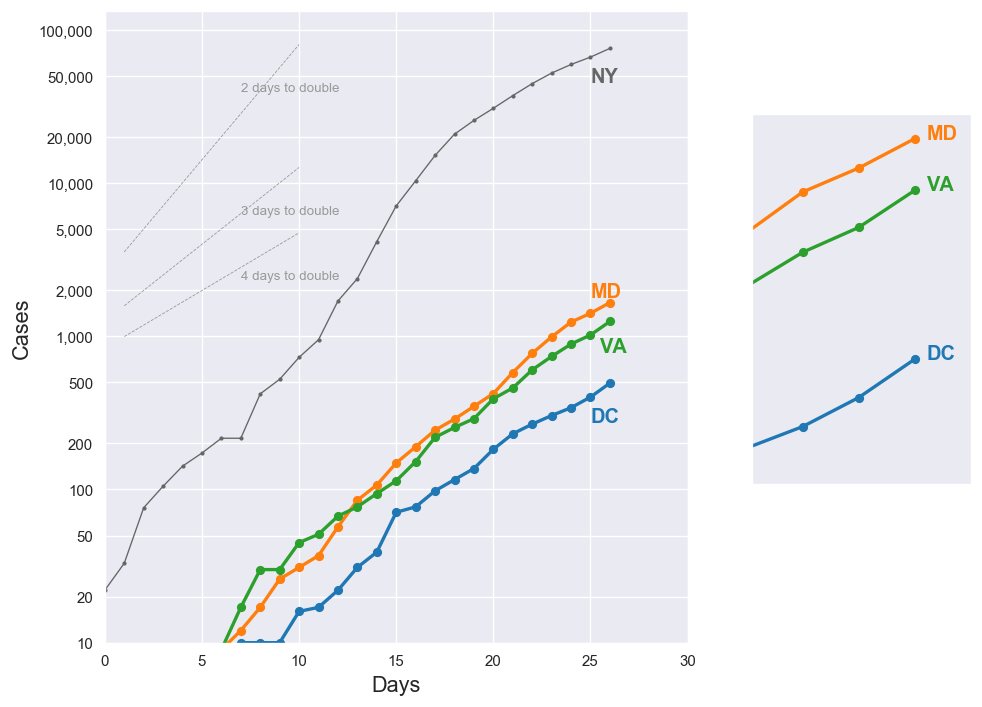

In [84]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=r_[1,1]*6, dpi=120)

xlim = r_[0,30]

todayx = 0 #26
def plot_state(state='DC', ax=ax, is_inset=False):
    global todayx
    desIx = ctDf.state == state
    ys = ctDf.loc[desIx,'positive']
    dtV = pd.to_datetime(ctDf.loc[desIx,'date'], format='%Y%m%d')
    print(f'Latest data for {state}: {dtV.iloc[0]}')
    xs = (dtV - dtV.iloc[-1]) 
    xs = r_[[x.days for x in xs]] + params.loc[state, 'xoff'] #- todayx

    ctDf.loc[desIx,'day0'] = xs


    ph, = ax.plot(xs, ys, marker='.', label=state, lw=2, markersize=9)
    if state in params.index:
        if is_inset:
            xytext = r_[7,0]
            xy=(xs[0],ys.iloc[0])
        else:
            xytext = (params.loc[state,'labXOff'], params.loc[state,'labYOff'])
            xy=(xs[1],ys.iloc[1])
            
        ah = ax.annotate(state, 
                         xy=xy, xycoords='data', xytext=xytext, textcoords='offset points',
                         color=ph.get_color(),
                         fontweight='bold', fontsize=12)

        lw = params.loc[state,'lw']
        ph.set_linewidth(lw)
        if lw < 1:
            ph.set_markersize(3)
            ph.set_color('0.4')
            ah.set_color('0.4')
    todayx = np.max((todayx, np.max(xs)))

plot_state('DC')
plot_state('MD')
plot_state('VA')
plot_state('NY')

def fixups(ax=ax):
    lp = r_[1,2,5]
    yt = np.hstack((lp*10,lp*10**2,lp*10**3,lp*10**4,10**5))
    #ax.set_yticks(yt)
    ax.set_yscale('log')
    plt.setp(ax.get_xticklabels(), fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(yt, nbins=len(yt)+1))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos: '{:,.0f}'.format(x)))

    ax.set_xlim(xlim)
    ax.set_ylim([10, ax.get_ylim()[1]])

fixups(ax)

ylim = ax.get_ylim()
ax.set_ylabel('Cases', fontsize=13)
ax.set_xlabel('Days', fontsize=13)

# guide lines
#xs = r_[3,xlim[1]+2]
xs = r_[1,10]
dtL = [2,3,4]
for (iD,dt) in enumerate(dtL):
    ys = 2**(xs/dt)
    y2 = ys*10**3.4/(iD+1)
    ax.plot(xs, y2, '--', lw=0.5, color='0.6')
    ax.annotate('%d days to double'%dt, xy=(7,y2[1]/2), xycoords='data', fontsize=8, color='0.6')



# inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
asp = ax.get_aspect()
print(asp)
with sns.axes_style('darkgrid'):
    r0 = 1.4
    axins = inset_axes(ax, width=1.3*r0, height=2.2*r0, bbox_to_anchor=(1.2,0.25,0.3,0.6), bbox_transform=ax.transAxes)
axins.set_facecolor('#EAEAF2')
for st in ['DC', 'MD', 'VA']:
    plot_state(st, ax=axins, is_inset=True)
fixups(ax=axins)

axins.set_xlim([todayx-2.9,todayx+1.0])
axins.set_ylim((250,1900))

axins.set_xticks([])
#axins.set_yticks((200,500,1000), [''])#(200,500,1000))
#axins.set_yticks([0])
axins.yaxis.set_visible(False)
axins.set_yticklabels([])
axins.xaxis.set_visible(False)

xs = r_[1,4]
dtL = [2,3,4]
for (iD,dt) in enumerate(dtL):
    ys = 2**(xs/dt)
    y2 = ys*10**2.3#/(iD+1)
    #axins.plot(xs+24, y2, '--', lw=0.5, color='0.6')
    #ax.annotate('%d days to double'%dt, xy=(7,y2[1]/2), xycoords='data', fontsize=8, color='0.6')

#ax.axvline(todayx, ls=':', color='0.5', lw=0.25)

fig.tight_layout()
fig.savefig('./fig-output/ct-%s.png'%datestr, dpi=300, bbox_inches='tight', bbox_extra_artists=[axins], pad_inches=0.5)
            #bbox_inches=r_[0,0,10,15])#, 

In [62]:
todayx

26